Нашел ссылку: [Затыкать пропуски нейронкой](https://datawig.readthedocs.io/en/latest/)

Поехали еще полезные ссылки: [сравнение пандас и альтернатив](https://www.datacamp.com/tutorial/benchmarking-high-performance-pandas-alternatives)

[Еще сравнение](https://www.datacamp.com/tutorial/high-performance-data-manipulation-in-python-pandas2-vs-polars)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandasql as ps
import duckdb as db
import pyarrow


In [14]:
# pyarrow.__version__

In [8]:
# !pip install --upgrade pyarrow
# !pip install --upgrade pandas (>=2.0.0)

In [40]:
# !pip install --upgrade matplotlib

In [47]:
# !pip install --upgrade graphviz

In [17]:
import polars as pl

In [9]:
q = '''
SELECT 1 as a
'''
db.query(q).to_df()

,a
0,1


In [10]:
lastfm = pd.read_csv('lastfm.csv', 
                     engine = 'pyarrow'
                    )

In [13]:
lastfm.head(1)

,album href,album tag,album page,album num,album name,album artist,album cover href,album listeners,album scrobbles,album tracks_total,album length,album release date,track pos,track name,track duration,track listeners,track scrobbles,track href
0,https://www.last.fm/music/Linkin+Park/Minutes+...,rock,1,1,Minutes to Midnight,Linkin Park,https://lastfm.freetls.fastly.net/i/u/300x300/...,1910153,52463554,12,,11 May 2007,1,Wake,,392738,2282570,https://www.last.fm/music/Linkin+Park/Minutes+...


In [39]:
%%time
lastfm['datetime_pandas'] = pd.to_datetime(lastfm['album release date'])

CPU times: user 464 ms, sys: 14.7 ms, total: 478 ms
Wall time: 488 ms


In [15]:
%%time
lastfm['datetime_pandas'] = lastfm['album release date'].apply(pd.to_datetime)

CPU times: user 26.2 s, sys: 613 ms, total: 26.9 s
Wall time: 27.5 s


In [40]:
lastfm['datetime_pandas'].dtype

dtype('<M8[ns]')

# Сколько альбомов выходило за каждый конкретный год (из датасета)
## Ответ - график Оx - Год, Oy - сколько было альбомов

In [33]:
lastfm[lastfm['album release date'].isna()]

(1089, 19)

In [36]:
lastfm.columns

Index(['album href', 'album tag', 'album page', 'album num', 'album name',
       'album artist', 'album cover href', 'album listeners',
       'album scrobbles', 'album tracks_total', 'album length',
       'album release date', 'track pos', 'track name', 'track duration',
       'track listeners', 'track scrobbles', 'track href', 'datetime_pandas'],
      dtype='object')

In [48]:
lastfm['album_year'] = lastfm['album release date'].apply(str).apply(lambda x: x[-4:])

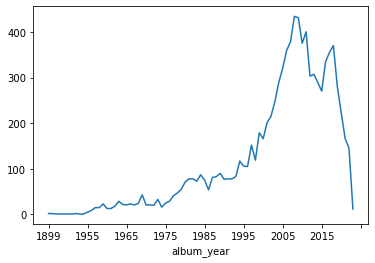

In [50]:
lastfm[~lastfm['album release date'].isna()]\
.groupby('album_year')\
['album href']\
.nunique().plot()

# Сколько в среднем композиций в альбоме

In [61]:
lastfm['track duration'] = lastfm['track duration'].fillna('0')

In [67]:
def get_sec(x):
    x = x.split(':')
    try:
        return int(x[0])*60 + int(x[1])
    except:
        return 0

In [66]:
get_sec('0:40')

40

In [68]:
lastfm['duration'] = lastfm['track duration'].swifter.apply(get_sec)

Pandas Apply:   0%|          | 0/142335 [00:00<?, ?it/s]

In [69]:
lastfm[lastfm.duration != 0].shape

(124164, 21)

# У какого исполнителя в датасете наибольшее число альбомов

In [81]:
lastfm.groupby('album href').size().mean()

15.122715682107946

In [88]:
lastfm.groupby('album href').size().mean()

lastfm.groupby('album artist')['album href']\
.nunique()\
.reset_index()\
.sort_values(by = 'album href').tail(5)

,album artist,album href
3533,Queen,21
2497,Lana Del Rey,23
2199,Johnny Cash,23
568,Bob Marley & The Wailers,26
4799,Various Artists,36


In [ ]:
lastfm.groupby('album artist')['album href'].nunique().reset_index().top

# Сколько в среднем длина композиции в зависимости от "жанра"

In [94]:
lastfm[lastfm['duration'] != 0]\
.groupby('album tag')['duration']\
.agg(['mean', 'median'])\
.sort_values(by = 'mean', ascending = False)

,mean,median
album tag,,
classical,253.449623,214.0
metal,252.652731,240.0
jazz,252.054495,224.0
modern classical,248.974906,214.0
80s,246.917192,238.0
electronic,246.106606,235.0
neoclassical,245.282407,229.0
rock,235.646718,224.0
reggae,232.211008,225.0


# Про polars (простое)


In [18]:
import polars as pl

In [20]:
import numpy as np

num_rows = 5000
rng = np.random.default_rng(seed=7)

buildings_data = {
     "sqft": rng.exponential(scale=1000, size=num_rows),
     "year": rng.integers(low=1995, high=2023, size=num_rows),
     "building_type": rng.choice(["A", "B", "C"], size=num_rows),
 }
buildings = pl.DataFrame(buildings_data)

In [22]:
# Сработало как в pandas
buildings.head(2)

sqft,year,building_type
f64,i64,str
707.529256,1996,"""C"""
1025.203348,2020,"""C"""


In [23]:
buildings.schema

OrderedDict([('sqft', Float64), ('year', Int64), ('building_type', Utf8)])

In [24]:
buildings.describe()

describe,sqft,year,building_type
str,f64,f64,str
"""count""",5000.0,5000.0,"""5000"""
"""null_count""",0.0,0.0,"""0"""
"""mean""",994.094456,2008.5258,null
"""std""",1016.641569,8.062353,null
"""min""",1.133256,1995.0,"""A"""
"""25%""",286.807549,2001.0,null
"""50%""",669.406964,2009.0,null
"""75%""",1343.539279,2015.0,null
"""max""",9307.793917,2022.0,"""C"""


## Select

In [27]:
# 1 вариант
buildings.select("sqft").head()

sqft
f64
707.529256
1025.203348
568.548657
895.109864
206.532754


In [28]:
# 2 вариант (он покруче)
buildings.select(pl.col("sqft")).head()

sqft
f64
707.529256
1025.203348
568.548657
895.109864
206.532754


In [30]:
# потому что тут можно сразу преобразование запихать
buildings.select(pl.col("sqft").sort() / 1000).head()

sqft
f64
0.001133
0.001152
0.001429
0.001439
0.001505


In [50]:
df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", None],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "C", "B"],
    }
)

out = df.select(
    pl.sum("nrs"),
    pl.col("names").sort(),
    pl.col("names").first().alias("first name"),
    (pl.mean("nrs") * 10).alias("10xnrs"),
)
print(out)

shape: (5, 4)
┌─────┬───────┬────────────┬────────┐
│ nrs ┆ names ┆ first name ┆ 10xnrs │
│ --- ┆ ---   ┆ ---        ┆ ---    │
│ i64 ┆ str   ┆ str        ┆ f64    │
╞═════╪═══════╪════════════╪════════╡
│ 11  ┆ null  ┆ foo        ┆ 27.5   │
│ 11  ┆ egg   ┆ foo        ┆ 27.5   │
│ 11  ┆ foo   ┆ foo        ┆ 27.5   │
│ 11  ┆ ham   ┆ foo        ┆ 27.5   │
│ 11  ┆ spam  ┆ foo        ┆ 27.5   │
└─────┴───────┴────────────┴────────┘


In [51]:
df = df.with_columns(
    pl.sum("nrs").alias("nrs_sum"),
    pl.col("random").count().alias("count"),
)
print(df)

shape: (5, 6)
┌──────┬───────┬──────────┬────────┬─────────┬───────┐
│ nrs  ┆ names ┆ random   ┆ groups ┆ nrs_sum ┆ count │
│ ---  ┆ ---   ┆ ---      ┆ ---    ┆ ---     ┆ ---   │
│ i64  ┆ str   ┆ f64      ┆ str    ┆ i64     ┆ u32   │
╞══════╪═══════╪══════════╪════════╪═════════╪═══════╡
│ 1    ┆ foo   ┆ 0.397265 ┆ A      ┆ 11      ┆ 5     │
│ 2    ┆ ham   ┆ 0.596384 ┆ A      ┆ 11      ┆ 5     │
│ 3    ┆ spam  ┆ 0.227886 ┆ B      ┆ 11      ┆ 5     │
│ null ┆ egg   ┆ 0.489214 ┆ C      ┆ 11      ┆ 5     │
│ 5    ┆ null  ┆ 0.092062 ┆ B      ┆ 11      ┆ 5     │
└──────┴───────┴──────────┴────────┴─────────┴───────┘


## Filter

In [31]:
# Конечно же, раз есть select, то есть и filter

after_2015 = buildings.filter(pl.col("year") > 2015)
after_2015.shape


(1230, 3)

In [32]:
after_2015.select(pl.col("year").min())

year
i64
2016


## Group_by

In [35]:
buildings.group_by("building_type").agg(
    [
        pl.mean("sqft").alias("mean_sqft"),
        pl.median("year").alias("median_year"),
        pl.count(),
    ]
)

building_type,mean_sqft,median_year,count
str,f64,f64,u32
"""C""",999.854722,2009.0,1692
"""A""",989.539918,2009.0,1653
"""B""",992.754444,2009.0,1655


In [52]:
out = df.group_by("groups").agg(
    pl.sum("nrs"),  # sum nrs by groups
    pl.col("random").count().alias("count"),  # count group members
    # sum random where name != null
    pl.col("random").filter(pl.col("names").is_not_null()).sum().suffix("_sum"),
    pl.col("names").reverse().alias("reversed names"),
)
print(out)

shape: (3, 5)
┌────────┬─────┬───────┬────────────┬────────────────┐
│ groups ┆ nrs ┆ count ┆ random_sum ┆ reversed names │
│ ---    ┆ --- ┆ ---   ┆ ---        ┆ ---            │
│ str    ┆ i64 ┆ u32   ┆ f64        ┆ list[str]      │
╞════════╪═════╪═══════╪════════════╪════════════════╡
│ B      ┆ 8   ┆ 2     ┆ 0.227886   ┆ [null, "spam"] │
│ C      ┆ 0   ┆ 1     ┆ 0.489214   ┆ ["egg"]        │
│ A      ┆ 3   ┆ 2     ┆ 0.993649   ┆ ["ham", "foo"] │
└────────┴─────┴───────┴────────────┴────────────────┘


# Плохое поле из Reverb

In [39]:
reverb = pd.read_csv('/Users/i.pile/reverb_aggregated.csv')

In [36]:
import json

In [37]:
eval('10.5436272')

10.5436272

In [38]:
# reverb['param_dict'] = reverb['param_dict'].swifter.apply(eval)

Pandas Apply:   0%|          | 0/31920 [00:00<?, ?it/s]

In [40]:
reverb.columns

Index(['title', 'description', 'text', 'param_dict', 'price', 'listing_id'], dtype='object')

# Сколько уникальных объявлений?

In [41]:
reverb = reverb.drop('listing_id', axis = 1)

In [42]:
reverb = reverb.drop_duplicates()

In [45]:
reverb = reverb.reset_index(drop = True)


In [46]:
import os
os.getcwd()

'/Users/i.pile/Documents/GitHub/DPO_Python_2023/lect15_Pandas_v2'

In [47]:
reverb.to_csv('/Users/i.pile/Documents/GitHub/Python_2023_Master/test_data/reverb.csv')

In [137]:

(np.array([[1,2],[3,4]])).flatten()

array([1, 2, 3, 4])

In [24]:
from matplotlib.cbook import flatten

In [25]:
from matplotlib.cbook import flatten
len(set(flatten(reverb.param_dict.apply(lambda x: x.keys()))))

33

In [26]:
fields_list = set(flatten(reverb.param_dict.apply(lambda x: x.keys())))

In [27]:
fields_list

{'Artist',
 'Body Material',
 'Body Shape',
 'Body Type',
 'Brand',
 'Bridge/Tailpiece Type',
 'Categories',
 'Color Family',
 'Condition',
 'Finish',
 'Finish Features',
 'Finish Style',
 'Fretboard Material',
 'Fretboard Radius',
 'Frets',
 'Made In',
 'Model',
 'Model Family',
 'Model Sub-Family',
 'Neck Construction',
 'Neck Material',
 'Number of Frets',
 'Number of Strings',
 'Nut Width',
 'Offset Body',
 'Pickup Configuration',
 'Product Family',
 'Right / Left Handed',
 'Scale Length',
 'Series',
 'Top Material',
 'Wood Top Style',
 'Year'}

# Добавить эти 33 поля в датафрейм, если пусто, писать ''

In [28]:
from tqdm import tqdm

In [29]:
for el in tqdm(fields_list):
    reverb[el] = reverb['param_dict'].apply(lambda x: x.get(el, ''))

100%|██████████| 33/33 [00:00<00:00, 82.59it/s]


In [30]:
reverb = reverb.reset_index(drop = True)

# Видна ли зависимость цены и длины описания (какая-то)

In [170]:
float(reverb.loc[0].price[1:].replace(',',''))

1131.92

In [176]:
reverb['price_num'] = reverb['price'].apply(lambda x: float(x[1:].replace(',','')))

In [178]:
reverb['text_len_sym'] = reverb['text'].apply(len)

In [184]:
import re
reverb['text_len_words'] = reverb['text'].apply(lambda x: len(re.findall(r'\w+', x)))

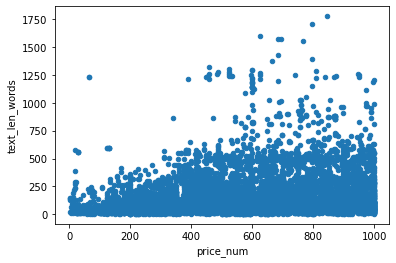

In [186]:
reverb[['price_num', 'text_len_words']][reverb.price_num <= 1000]\
.plot(kind = 'scatter', x= 'price_num',y = 'text_len_words')

In [187]:
reverb['price_group'] = reverb['price_num'].apply(lambda x: (x//100)*100)

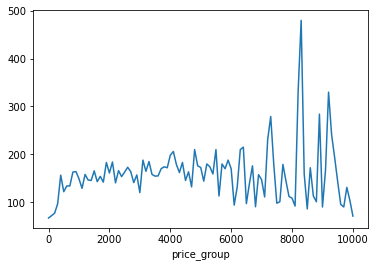

In [190]:
reverb[reverb.price_num <= 10000].groupby('price_group')['text_len_words'].median().plot()